Computations in single precision
================================

```{versionadded} 3.2.0

```

In previous tutorials we saw how heyoka.py, in addition to the standard [double precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format), also supports computations in [extended precision](./ext_precision.ipynb) and [arbitrary precision](./arbitrary_precision.ipynb). Starting with version 3.2.0, heyoka.py supports also computations in [single precision](https://en.wikipedia.org/wiki/Single-precision_floating-point_format).

Single-precision computations can lead to substantial performance benefits when high accuracy is not required. In particular, single-precision [batch mode](<./Batch mode overview.ipynb>) can use a SIMD width twice larger than double precision, leading to an increase by a factor of 2 of the computational throughput. In scalar computations, the use of single precision reduces by half the memory usage with respect to double precision, which can help alleviating performance issues in large ODE systems. This can be particularly noticeable in applications such as [neural ODEs](./NeuralODEs.ipynb).

In NumPy, single-precision values are represented via the {py:class}`numpy.single` data type. Correspondingly, and similarly to what explained in the [extended precision](./ext_precision.ipynb) and [arbitrary precision](./arbitrary_precision.ipynb) tutorials, single-precision computations are activated by passing the ``fp_type=numpy.single`` keyword argument to functions and classes in the heyoka.py API.

The pendulum example
--------------------

Let us begin as usual with the definition of the dynamical equations:

In [1]:
import heyoka as hy

# Pendulum dynamics.
dyn = hy.model.pendulum()

# Pendulum energy.
en = hy.model.pendulum_energy()

Next, we are going to create an integrator object in single precision:

In [2]:
import numpy as np

ta = hy.taylor_adaptive(dyn,
                        # Initial conditions in single precision.
                        np.array([-1, 0], dtype=np.single),
                        # Specify that the integrator must operate
                        # in single precision.
                        fp_type=np.single)

[2024-02-12 08:04:03.202] [heyoka] [info] heyoka logger initialised


As usual, the default integration tolerance is the epsilon of the floating-point type in use. This can be confirmed by examining the screen output of the ``ta`` object:

In [3]:
ta

C++ datatype            : float
Tolerance               : 1.1920929e-07
High accuracy           : false
Compact mode            : false
Taylor order            : 9
Dimension               : 2
Time                    : 0
State                   : [-1, 0]

Next, we are going to create a [compiled function](./compiled_functions.ipynb) for the computation of the energy of the system:

In [4]:
x, v = hy.make_vars("x", "v")

cf_en = hy.cfunc([en], fp_type=np.single,
                      vars=[x, v])

Note how we passed the ``fp_type=numpy.single`` argument to indicate that the compiled function should operate in single precision.

Let us compute and store the energy of the system:

In [5]:
orig_en = cf_en(ta.state)[0]

We proceed now with a numerical integration over a time grid, up to $t=300$:

In [6]:
# Create a time grid in single precision.
t_grid = np.linspace(0, 300, 100, dtype=np.single)
out = ta.propagate_grid(t_grid)[-1]

Again, note how we created the time grid in single precision.

We can now proceed with the computation and the visualisation of the energy error:

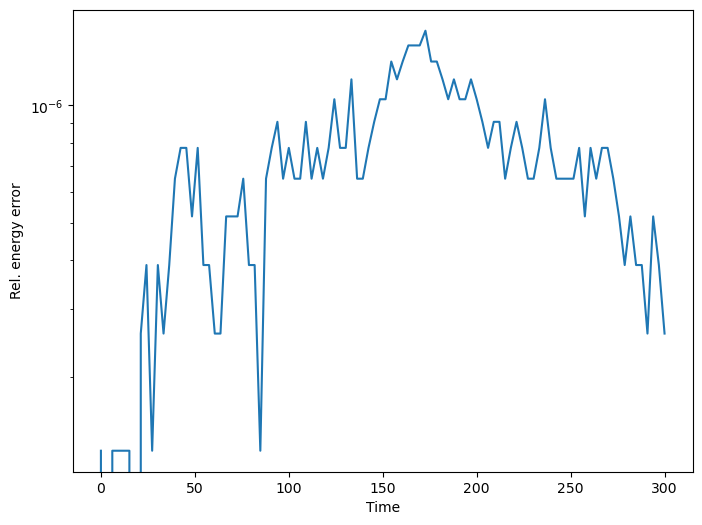

In [7]:
# Compute the relative energy error over the time grid.
en_hist = cf_en(np.ascontiguousarray(out.transpose()))
E_err = abs((orig_en - en_hist[0]) / orig_en)

# Plot the energy error.
from matplotlib.pylab import plt
fig = plt.figure(figsize=(8, 6))
plt.semilogy(t_grid, E_err)
plt.xlabel("Time")
plt.ylabel("Rel. energy error");

We can see indeed how the energy error is kept at around the epsilon of single precision.

Other classes and functions
---------------------------

Besides the adaptive integrator, several other classes and functions in heyoka.py can be used in single precision. The [event classes](<./Event detection.ipynb>), for instance, can be constructed in single precision:

In [8]:
# Construct a terminal event in single precision.
ev = hy.t_event(x, fp_type=np.single, cooldown=np.single(1e-8))

As with the adaptive integrator, in order to enable single precision we must pass the ``fp_type`` keyword argument, and any numerical quantity passed to the constructor (such as the cooldown in this specific case) must also be created in single precision.

Note that the precision of an event must match the precision of the integrator object in which the event is used, otherwise a runtime error will be raised during the construction of the integrator.